In [2]:
import pandas as pd
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate
import statsmodels.api as sm
from scipy import signal
import moepy

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%load_ext nb_black

<IPython.core.display.Javascript object>

--------------------------

## Question 1

In [3]:
def read_jj(filename):
    df = pd.read_csv(filename)
    df["log10"] = np.log10(df.jj)
    df.date = pd.to_datetime(df.date)
    df["time"] = [x + 1 for x in range(len(df.jj))]
    df["Q"] = df.date.dt.quarter
    df = pd.get_dummies(df, columns=["Q"], prefix_sep="")
    df["intercept"] = 1
    df.set_index("date", inplace=True)

    return df

<IPython.core.display.Javascript object>

In [4]:
JJ = read_jj("../data/jj.csv")

<IPython.core.display.Javascript object>

In [5]:
JJ

,jj,log10,time,Q1,Q2,Q3,Q4,intercept
date,,,,,,,,
1960-01-01,0.71,-0.148742,1,1,0,0,0,1
1960-04-01,0.63,-0.200659,2,0,1,0,0,1
1960-07-01,0.85,-0.070581,3,0,0,1,0,1
1960-10-01,0.44,-0.356547,4,0,0,0,1,1
1961-01-01,0.61,-0.214670,5,1,0,0,0,1
...,...,...,...,...,...,...,...,...
1979-10-01,9.99,0.999565,80,0,0,0,1,1
1980-01-01,16.20,1.209515,81,1,0,0,0,1
1980-04-01,14.67,1.166430,82,0,1,0,0,1


<IPython.core.display.Javascript object>

In [6]:
lm_mod = sm.OLS(endog=JJ.log10, exog=JJ[["time", "Q1", "Q2", "Q3", "Q4"]])
results = lm_mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log10   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1379.
Date:                Sun, 05 Feb 2023   Prob (F-statistic):           3.33e-72
Time:                        18:40:31   Log-Likelihood:                 127.87
No. Observations:                  84   AIC:                            -245.7
Df Residuals:                      79   BIC:                            -233.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.0182      0.000     73.999      0.000       0.018       0.019
Q1            -0.2869      0.016    -18.434      0.000      -0.318      -0.256
Q2            -0.2747      0.016    -17.470      0.000      -0.306      -0.243
Q3            -0.2443      0.016    -15.376      0.000      -0.276      -0.213
Q4            -0.3610      0.016    -22.490      0.000      -0.393      -0.329
==============================================================================
Omnibus:                        0.996   Durbin-Watson:                   1.274
Prob(Omnibus):                  0.608   Jarque-Bera (JB):                1.065
Skew:                           0.178   Prob(JB):                        0.587
Kurtosis:                       2.578   Cond. No.                         198.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [7]:
fitted = results.predict()

<IPython.core.display.Javascript object>

In [10]:
plt.rcParams["figure.figsize"] = (14, 8)

<IPython.core.display.Javascript object>

Text(0, 0.5, 'log_10(J&J Earnings)')

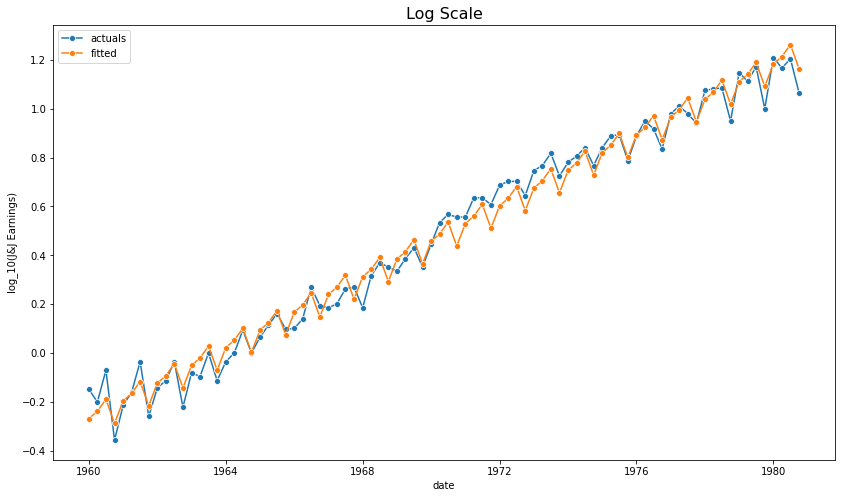

<IPython.core.display.Javascript object>

In [11]:
JJ["fitted"] = fitted

log_actuals = sns.lineplot(
    data=JJ.reset_index(), y="log10", x="date", marker="o", label="actuals"
)
log_fitted = sns.lineplot(
    data=JJ.reset_index(), y="fitted", x="date", marker="o", label="fitted"
)
log_actuals.set_title("Log Scale", fontsize=16)
log_actuals.set_ylabel("log_10(J&J Earnings)")

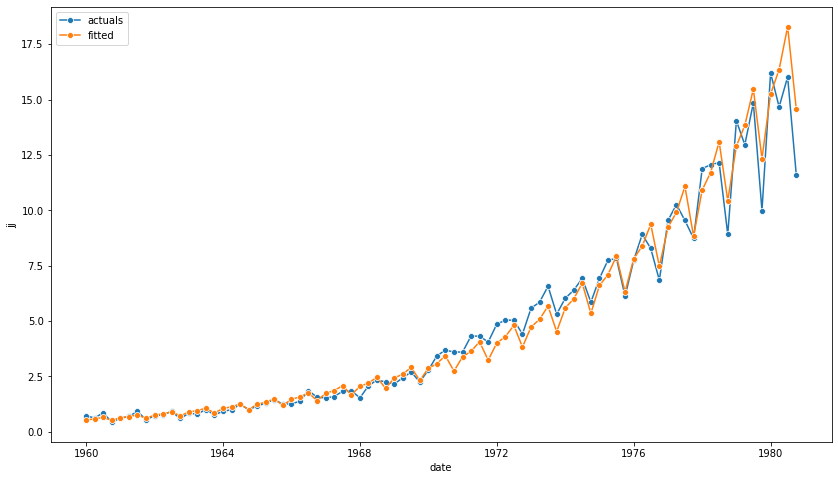

<IPython.core.display.Javascript object>

In [12]:
JJ["yhat"] = 10**fitted
actuals = sns.lineplot(
    data=JJ.reset_index(), y="jj", x="date", marker="o", label="actuals"
)
fitted_plot = sns.lineplot(
    data=JJ.reset_index(), y="yhat", x="date", marker="o", label="fitted"
)

Text(0, 0.5, 'Residuals')

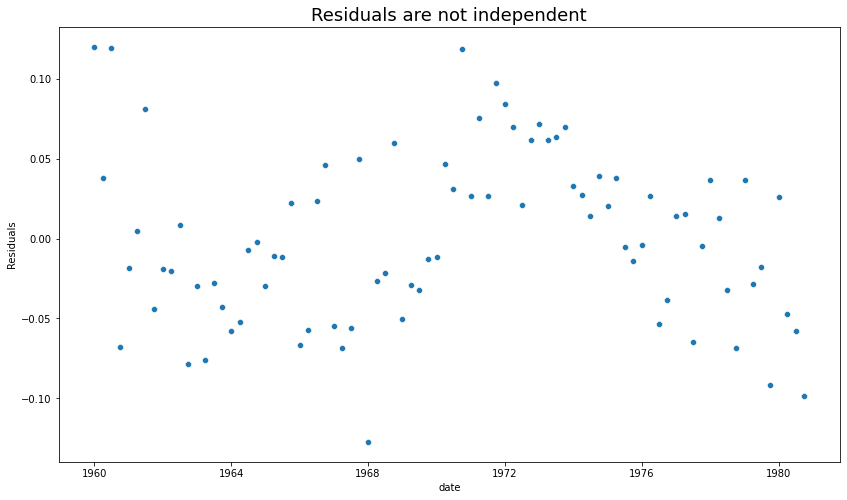

<IPython.core.display.Javascript object>

In [13]:
resid_plot = sns.scatterplot(
    data=results.resid,
)
resid_plot.set_title("Residuals are not independent", fontsize=18)
resid_plot.set_ylabel("Residuals")

## 2.2 Mortality

In [14]:
def read_mort(filename):
    df = pd.read_csv(filename)
    df.set_index("date", inplace=True)
    scaler = StandardScaler()
    df[["temp_std", "part_std"]] = scaler.fit_transform(df[["tempr", "part"]])
    # df["temp"] = df.tempr - np.mean(df.tempr)
    # df["temp2"] = df.temp**2
    df["temp2_std"] = df.temp_std**2
    df["part4_std"] = df.part_std.shift(4)
    df["time"] = [t + 1 for t in range(len(df.cmort))]

    keep_cols = ["cmort", "time", "temp_std", "temp2_std", "part_std", "part4_std"]
    df = df[keep_cols]
    df = df.iloc[5:, :]
    return df

<IPython.core.display.Javascript object>

In [15]:
mort = read_mort("../data/lap.csv")

<IPython.core.display.Javascript object>

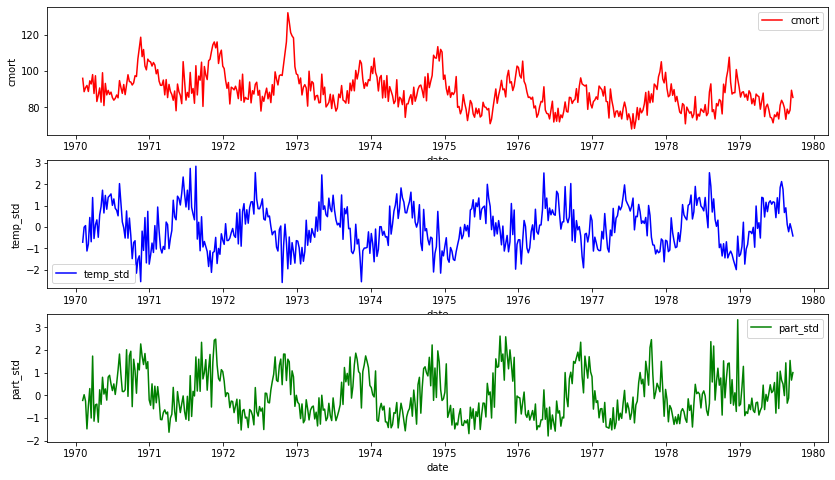

<IPython.core.display.Javascript object>

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

mort_plot = mort.copy()
mort_plot.reset_index(inplace=True)
mort_plot.date = pd.to_datetime(mort_plot.date)

sns.lineplot(data=mort_plot, x="date", y="cmort", color="red", ax=ax1, label="cmort")
sns.lineplot(
    data=mort_plot,
    x="date",
    y="temp_std",
    color="blue",
    ax=ax2,
    label="temp_std",
)
sns.lineplot(
    data=mort_plot,
    x="date",
    y="part_std",
    color="green",
    ax=ax3,
    label="part_std",
)
plt.show()

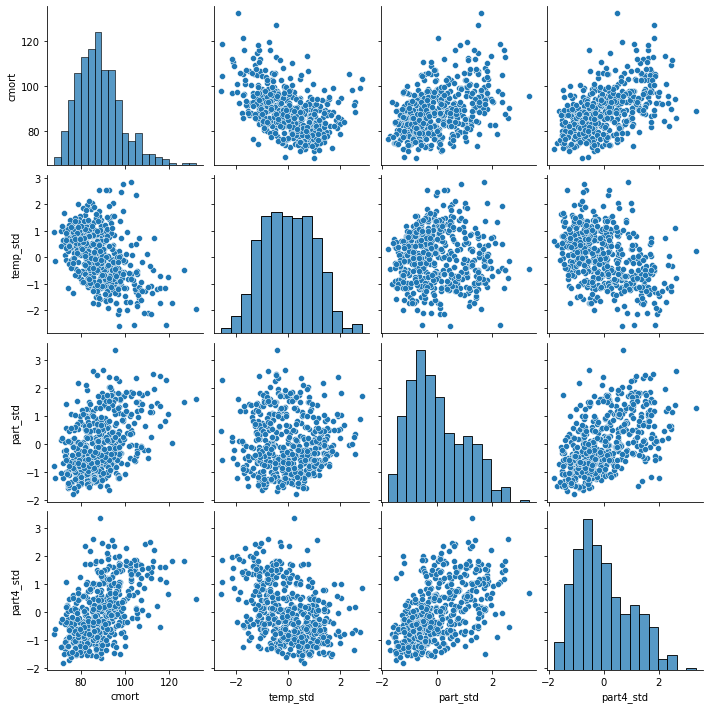

<IPython.core.display.Javascript object>

In [17]:
sns.pairplot(data=mort[["cmort", "temp_std", "part_std", "part4_std"]])

In [18]:
M1 = LinearRegression().fit(X=mort[["time"]], y=mort.cmort)
M2 = LinearRegression().fit(X=mort[["time", "temp_std"]], y=mort.cmort)
M3 = LinearRegression().fit(X=mort[["time", "temp_std", "temp2_std"]], y=mort.cmort)
M4 = LinearRegression().fit(
    X=mort[["time", "temp_std", "temp2_std", "part_std"]], y=mort.cmort
)
M5 = LinearRegression().fit(
    X=mort[["time", "temp_std", "temp2_std", "part_std", "part4_std"]], y=mort.cmort
)

<IPython.core.display.Javascript object>

In [19]:
def aic(mod, coef_names):
    pred_cmort = mod.predict(X=mort[coef_names])
    mse = mean_squared_error(y_true=mort.cmort, y_pred=pred_cmort)

    n = mort.shape[0]
    k = len(mod.coef_) + 1
    aic = np.log(mse) + (n + 2 * k) / n
    return aic


def bic(mod, coef_names):
    pred_cmort = mod.predict(X=mort[coef_names])
    mse = mean_squared_error(y_true=mort.cmort, y_pred=pred_cmort)

    n = mort.shape[0]
    k = len(mod.coef_) + 1
    aic = np.log(mse) + (k * np.log(n)) / n
    return aic

<IPython.core.display.Javascript object>

In [20]:
aic(M1, ["time"]), bic(M1, ["time"])

(5.382631437220267, 4.399413107876728)

<IPython.core.display.Javascript object>

In [21]:
aic(M2, ["time", "temp_std"]), bic(M2, ["time", "temp_std"])

(5.143840239994917, 4.169012745979607)

<IPython.core.display.Javascript object>

In [22]:
aic(M3, ["time", "temp_std", "temp2_std"]), bic(M3, ["time", "temp_std", "temp2_std"])

(5.030083430484785, 4.063646771797705)

<IPython.core.display.Javascript object>

In [23]:
aic(M4, ["time", "temp_std", "temp2_std", "part_std"]), bic(
    M4, ["time", "temp_std", "temp2_std", "part_std"]
)

(4.720639113340823, 3.7625932899819743)

<IPython.core.display.Javascript object>

In [24]:
aic(M5, ["time", "temp_std", "temp2_std", "part_std", "part4_std"]), bic(
    M5, ["time", "temp_std", "temp2_std", "part_std", "part4_std"]
)

(4.690092014318376, 3.740437026287756)

<IPython.core.display.Javascript object>

In [25]:
no_lag_mod = sm.OLS(
    endog=mort.cmort, exog=mort[["time", "temp_std", "temp2_std", "part_std"]]
)
results = no_lag_mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cmort   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.770
Method:                 Least Squares   F-statistic:                              422.5
Date:                Sun, 05 Feb 2023   Prob (F-statistic):                   1.18e-158
Time:                        18:40:49   Log-Likelihood:                         -2600.6
No. Observations:                 503   AIC:                                      5209.
Df Residuals:                     499   BIC:                                      5226.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.2106      0.008     27.626      0.000       0.196       0.226
temp_std      -7.2706      1.905     -3.817      0.000     -11.013      -3.528
temp2_std     15.5677      1.408     11.058      0.000      12.802      18.334
part_std       4.3133      1.917      2.250      0.025       0.546       8.080
==============================================================================
Omnibus:                       38.813   Durbin-Watson:                   0.351
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.963
Skew:                          -0.153   Prob(JB):                     0.000564
Kurtosis:                       2.213   Cond. No.                         301.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [26]:
lag_mod = sm.OLS(
    endog=mort.cmort,
    exog=mort[["time", "temp_std", "temp2_std", "part_std", "part4_std"]],
)
results = lag_mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cmort   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.770
Method:                 Least Squares   F-statistic:                              337.4
Date:                Sun, 05 Feb 2023   Prob (F-statistic):                   2.41e-157
Time:                        18:40:49   Log-Likelihood:                         -2600.5
No. Observations:                 503   AIC:                                      5211.
Df Residuals:                     498   BIC:                                      5232.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.2108      0.008     27.552      0.000       0.196       0.226
temp_std      -6.8998      2.158     -3.198      0.001     -11.139      -2.660
temp2_std     15.5134      1.417     10.950      0.000      12.730      18.297
part_std       3.8278      2.331      1.642      0.101      -0.753       8.408
part4_std      0.9395      2.562      0.367      0.714      -4.093       5.972
==============================================================================
Omnibus:                       38.856   Durbin-Watson:                   0.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.075
Skew:                          -0.158   Prob(JB):                     0.000533
Kurtosis:                       2.213   Cond. No.                         507.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## 2.3 RW with Drift

In [27]:
def generate_random_walk(steps=1000, drift=0, sigma_innovation=1):
    rng = default_rng()
    inno = rng.normal(loc=0, scale=sigma_innovation, size=steps)
    rw = np.cumsum(inno)
    drift_vals = [i * drift for i in range(len(rw))]

    walk = drift_vals + rw + inno
    return walk, inno, drift_vals

<IPython.core.display.Javascript object>

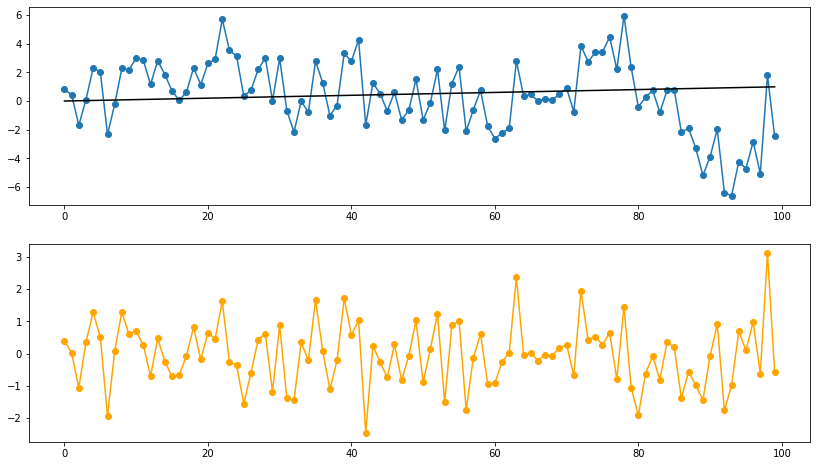

<IPython.core.display.Javascript object>

In [28]:
rw, inno, drift = generate_random_walk(100, drift=0.01, sigma_innovation=1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(rw, marker='o')
ax1.plot(drift, color='black')
ax2.plot(inno, marker='o', color='orange')


In [29]:
drift_mod = sm.OLS(endog=rw, exog=list(range(len(rw))))
drift_mod_res = drift_mod.fit()
drift_mod_res.params

array([-0.00354765])

<IPython.core.display.Javascript object>

In [30]:
drift_mod_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):             -0.003
Method:                 Least Squares   F-statistic:                             0.6636
Date:                Sun, 05 Feb 2023   Prob (F-statistic):                       0.417
Time:                        18:40:51   Log-Likelihood:                         -232.84
No. Observations:                 100   AIC:                                      467.7
Df Residuals:                      99   BIC:                                      470.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0035      0.004     -0.815      0.417      -0.012       0.005
==============================================================================
Omnibus:                        3.729   Durbin-Watson:                   0.823
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                3.175
Skew:                          -0.423   Prob(JB):                        0.204
Kurtosis:                       3.212   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## 2.8 Varve

In [31]:
def read_varve(filename):
    df = pd.read_csv(filename)
    df.columns = ["thickness"]
    df["log_thickness"] = np.log(df.thickness)
    df["log_diff"] = df.log_thickness - df.log_thickness.shift(1)
    df["time"] = [t + 1 for t in range(len(df.thickness))]
    df = df[["time", "thickness", "log_thickness", "log_diff"]]

    return df

<IPython.core.display.Javascript object>

In [32]:
varve = read_varve("../data/varve.csv")

<IPython.core.display.Javascript object>

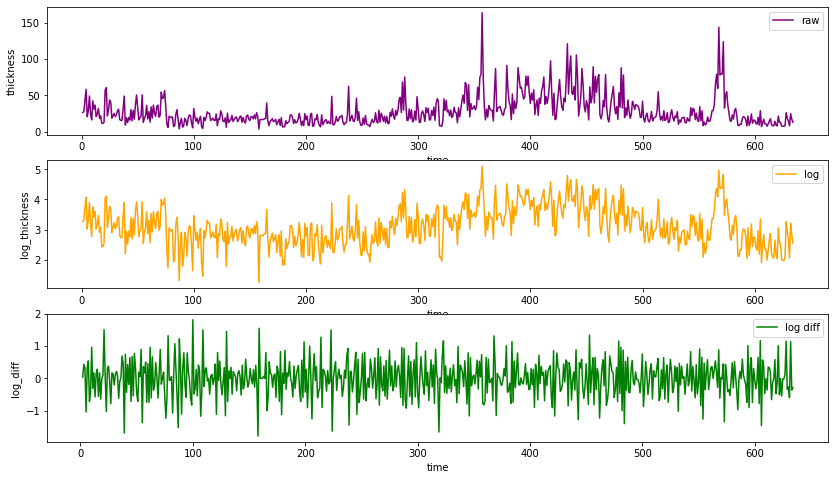

<IPython.core.display.Javascript object>

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

sns.lineplot(data=varve, x="time", y="thickness", color="purple", ax=ax1, label="raw")
sns.lineplot(
    data=varve, x="time", y="log_thickness", color="orange", ax=ax2, label="log"
)
sns.lineplot(
    data=varve, x="time", y="log_diff", color="green", ax=ax3, label="log diff"
)

plt.show()

In [34]:
varve["group"] = varve["time"] < len(varve) / 2

<IPython.core.display.Javascript object>

In [35]:
varve.groupby("group")[["thickness", "log_thickness"]].apply(np.std)

,thickness,log_thickness
group,,
False,24.312545,0.670274
True,11.469160,0.517765


<IPython.core.display.Javascript object>

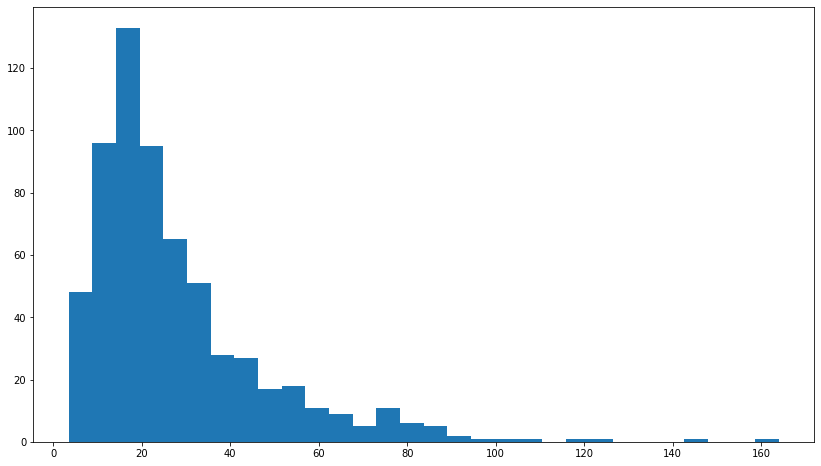

<IPython.core.display.Javascript object>

In [36]:
_ = plt.hist(varve.thickness, bins=30)

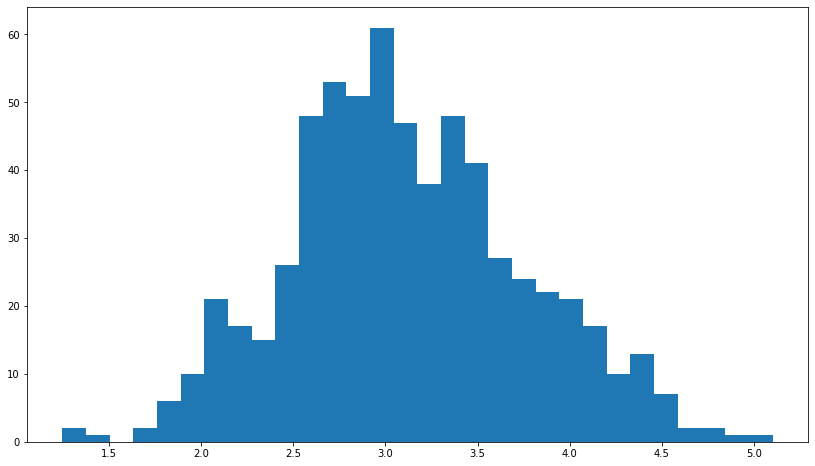

<IPython.core.display.Javascript object>

In [37]:
_ = plt.hist(varve.log_thickness, bins=30)

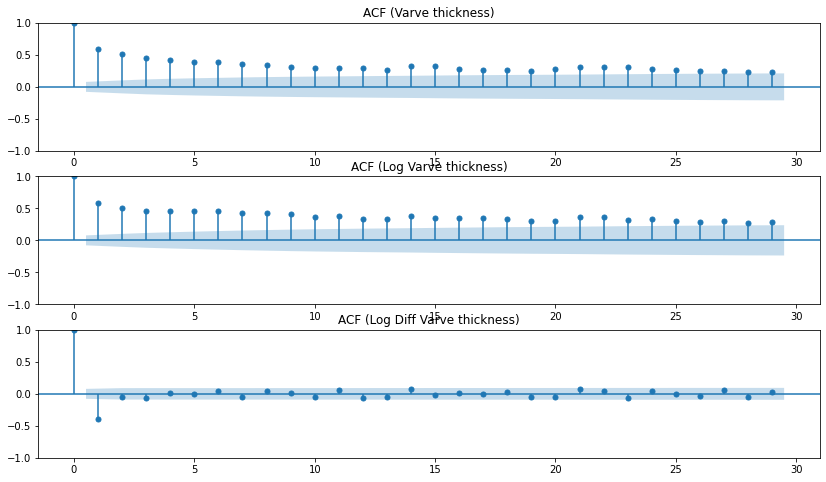

<IPython.core.display.Javascript object>

In [38]:
import statsmodels.api as sm

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
sm.graphics.tsa.plot_acf(varve.thickness, ax=ax1, title="ACF (Varve thickness)")
sm.graphics.tsa.plot_acf(varve.log_thickness, ax=ax2, title="ACF (Log Varve thickness)")
sm.graphics.tsa.plot_acf(
    varve.log_diff[1:-1], ax=ax3, title="ACF (Log Diff Varve thickness)"
)
plt.show()

In [39]:
gamma_1 = sm.tsa.acf(varve.log_diff[1:-1], nlags=1)[1]
sigma2_w = np.var(varve.log_diff[1:-1])
theta = -gamma_1 / sigma2_w

print(f"gamma_1: {gamma_1}")
print(f"sigma2_w: {sigma2_w}")
print(f"theta: {theta}")

gamma_1: -0.39807688045685596
sigma2_w: 0.33208332633305854
theta: 1.1987258886271517


<IPython.core.display.Javascript object>

## 2.9

<AxesSubplot: xlabel='date', ylabel='soi'>

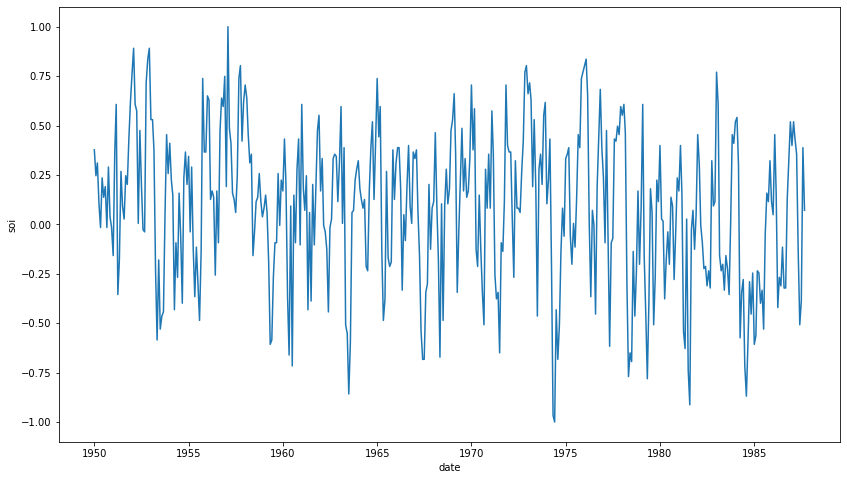

<IPython.core.display.Javascript object>

In [40]:
def read_soi(filename):
    df = pd.read_csv(filename)
    df.date = pd.to_datetime(df.date)
    df["time"] = pd.Series(range(len(df)))
    return df


soi = read_soi("../data/soi.csv")
sns.lineplot(data=soi, x="date", y="soi")

In [41]:
soi_reg = LinearRegression().fit(soi[["time"]], soi.soi)
soi["trend_soi"] = soi_reg.predict(soi[["time"]])
soi["detrended_soi"] = soi.soi - soi.trend_soi

<IPython.core.display.Javascript object>

<AxesSubplot: xlabel='date', ylabel='detrended_soi'>

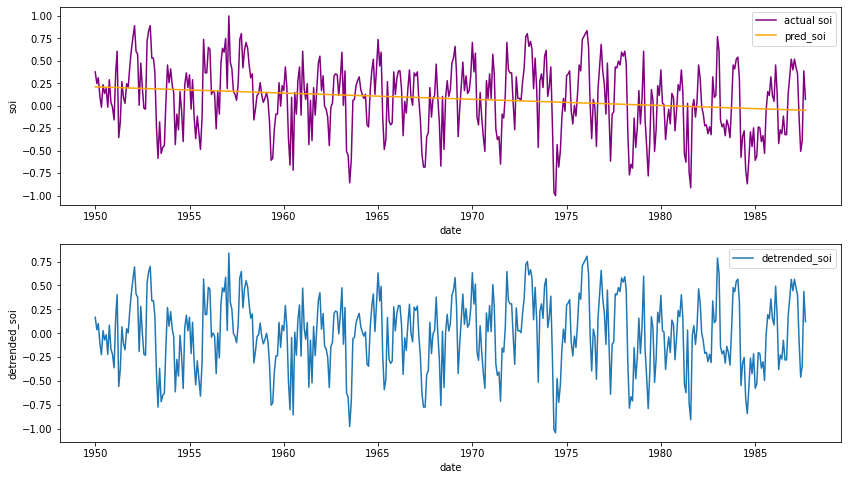

<IPython.core.display.Javascript object>

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1)
sns.lineplot(data=soi, x="date", y="soi", color="purple", label="actual soi", ax=ax1)
sns.lineplot(
    data=soi, x="date", y="trend_soi", color="orange", label="pred_soi", ax=ax1
)
sns.lineplot(data=soi, x="date", y="detrended_soi", label="detrended_soi")

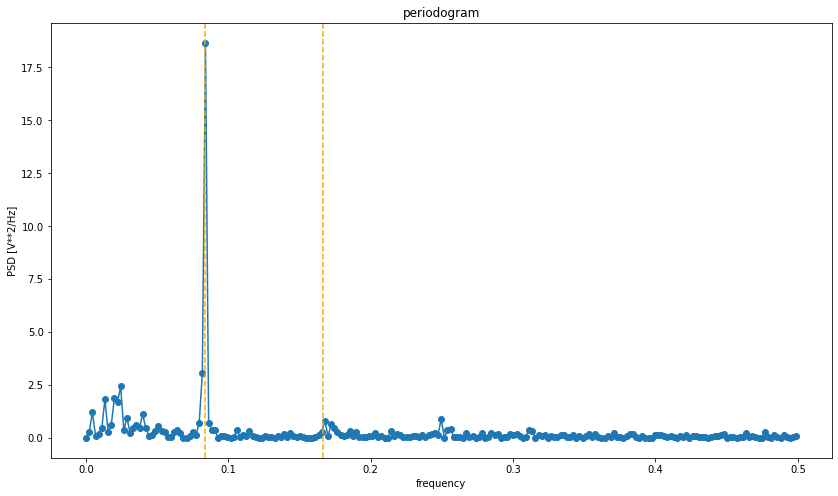

<IPython.core.display.Javascript object>

In [43]:
f, Pxx_den = signal.periodogram(soi.detrended_soi, 1)

plt.plot(f, Pxx_den, marker="o", label="PeriodoGram")
plt.axvline(x=1 / 12, color="orange", linestyle="dashed")
plt.axvline(x=2 / 12, color="orange", linestyle="dashed")
# plt.axvline(x=3 / 12, color="orange", linestyle="dashed")
plt.xlabel("frequency")
plt.ylabel("PSD [V**2/Hz]")
plt.title("periodogram")
plt.show()

# 2.11

In [44]:
def read_oil(filename):
    df = pd.read_csv(filename)
    df.date = pd.to_datetime(df.date)
    df["log_oil"] = np.log(df.oil)
    df["log_gas"] = np.log(df.gas)

    df["poil"] = df.log_oil - df.log_oil.shift(1)
    df["pgas"] = df.log_gas - df.log_gas.shift(1)

    return df


oil = read_oil("../data/oil.csv")
oil.head()

,date,oil,gas,log_oil,log_gas,poil,pgas
0,2000-01-01,26.20,70.636,3.265759,4.257540,NaN,NaN
1,2000-01-08,26.07,71.040,3.260785,4.263243,-0.004974,0.005703
2,2000-01-15,26.34,68.490,3.271089,4.226688,0.010303,-0.036555
3,2000-01-22,24.95,65.137,3.216874,4.176493,-0.054215,-0.050195
4,2000-01-29,26.27,67.918,3.268428,4.218301,0.051554,0.041808


<IPython.core.display.Javascript object>

# (a)

Looks like a Random Walk with drift.

Non stationary

<AxesSubplot: xlabel='date'>

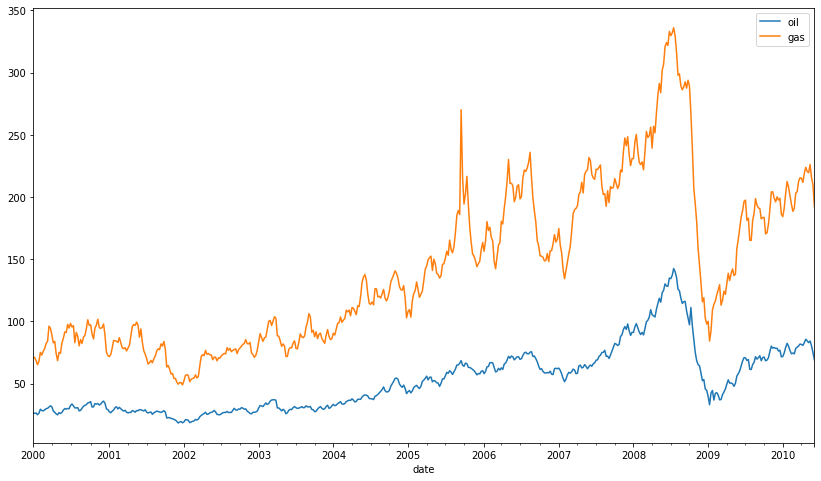

<IPython.core.display.Javascript object>

In [45]:
oil.set_index("date")[["oil", "gas"]].plot()

## (c)


<AxesSubplot: xlabel='date'>

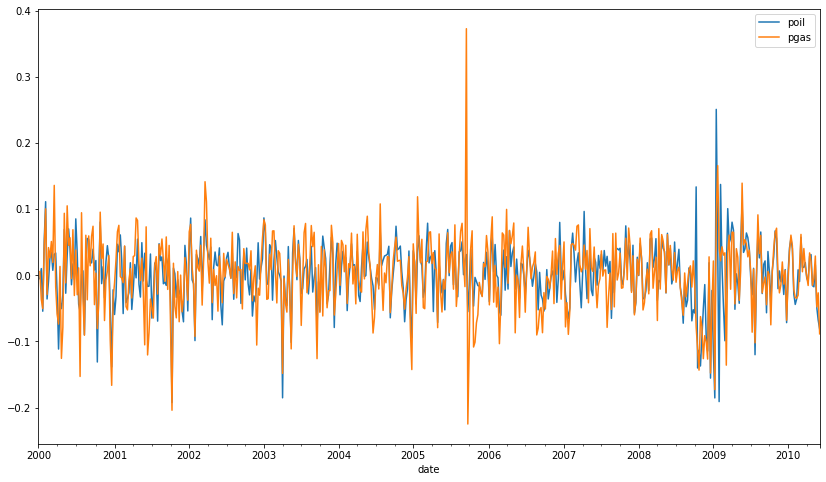

<IPython.core.display.Javascript object>

In [46]:
oil.set_index("date")[["poil", "pgas"]].plot()

In [47]:
# https://stackoverflow.com/questions/63491991/how-to-use-the-ccf-method-in-the-statsmodels-library
def ccf(series1, series2):
    backwards = sm.tsa.stattools.ccf(series2, series1, adjusted=False)[::-1]
    forwards = sm.tsa.stattools.ccf(series1, series2, adjusted=False)
    ccf_output = np.r_[backwards[:-1], forwards]
    return backwards, forwards
    return ccf_output


<IPython.core.display.Javascript object>

In [48]:
back, forw = ccf(oil.poil[1:], oil.pgas[1:])
# ccf_output = ccf(oil.poil[1:], oil.pgas[1:])

<IPython.core.display.Javascript object>

In [49]:
ccf_plot_data = np.r_[back[-11:-1], forw[:11]]

<IPython.core.display.Javascript object>

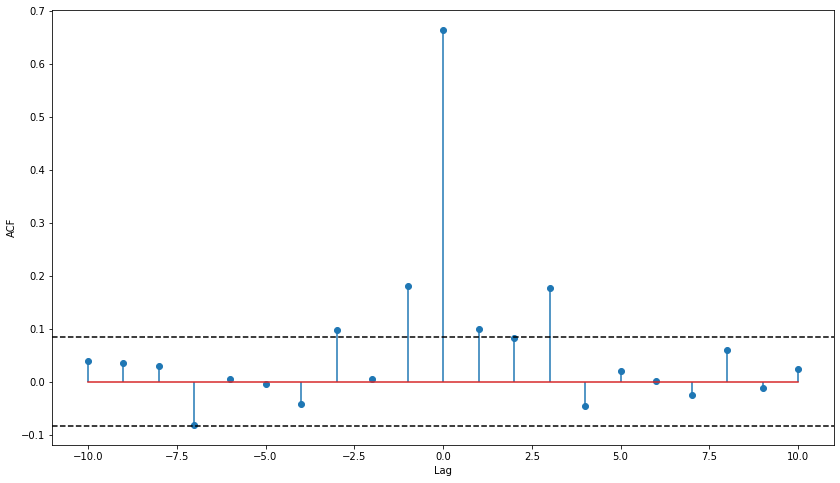

<IPython.core.display.Javascript object>

In [51]:
plt.stem(range(-10, 11), ccf_plot_data)
plt.xlabel('Lag')
plt.ylabel('ACF')
# 95% UCL / LCL
plt.axhline(-1.96/np.sqrt(len(oil)), color='k', ls='--') 
plt.axhline(1.96/np.sqrt(len(oil)), color='k', ls='--')


## (e)

In [52]:
oil["pgas1"] = oil.pgas.shift(-1)
oil["pgas2"] = oil.pgas.shift(-2)
oil["pgas3"] = oil.pgas.shift(-3)

<IPython.core.display.Javascript object>

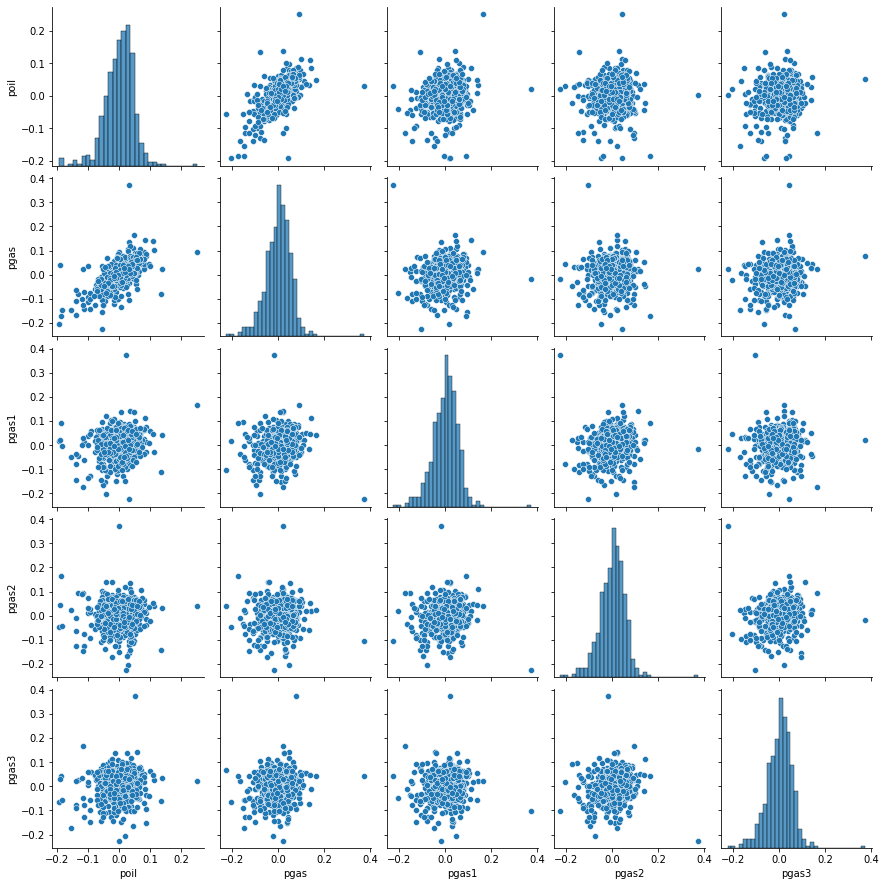

<IPython.core.display.Javascript object>

In [53]:
sns.pairplot(oil[["poil", "pgas", "pgas1", "pgas2", "pgas3"]])

## (f)
Fit Regression: G_t = alpha_1 + alpha_2 Inid + beta_1 O_t + beta_2 O_{t-1} + w_t

In [54]:
oil["indi"] = np.where(oil.poil >= 0, 1, 0)
oil["poil1"] = oil.poil.shift(1)
oil.head()

,date,oil,gas,log_oil,log_gas,poil,pgas,pgas1,pgas2,pgas3,indi,poil1
0,2000-01-01,26.20,70.636,3.265759,4.257540,NaN,NaN,0.005703,-0.036555,-0.050195,0,NaN
1,2000-01-08,26.07,71.040,3.260785,4.263243,-0.004974,0.005703,-0.036555,-0.050195,0.041808,0,NaN
2,2000-01-15,26.34,68.490,3.271089,4.226688,0.010303,-0.036555,-0.050195,0.041808,0.100746,1,-0.004974
3,2000-01-22,24.95,65.137,3.216874,4.176493,-0.054215,-0.050195,0.041808,0.100746,-0.028999,0,0.010303
4,2000-01-29,26.27,67.918,3.268428,4.218301,0.051554,0.041808,0.100746,-0.028999,0.042079,1,-0.054215


<IPython.core.display.Javascript object>

In [55]:
mod_data = oil[['poil', 'pgas', 'indi', 'poil1']].copy()
mod_data.dropna(inplace=True)
reg_mod = LinearRegression(fit_intercept=True).fit(X=mod_data[['indi', 'poil', 'poil1']], y=mod_data.pgas)
# reg_mod = LinearRegression(fit_intercept=True).fit(X=mod_data[['poil', 'poil1']], y=mod_data.pgas)


<IPython.core.display.Javascript object>

In [56]:
print(f"Intercept: \t{reg_mod.intercept_}")
print(f"Indi: \t\t{reg_mod.coef_[0]}")
print(f"poil: \t\t{reg_mod.coef_[1]}")
print(f"poil1: \t\t{reg_mod.coef_[2]}")

# print(f"Intercept: \t{reg_mod.intercept_}")
# print(f"poil: \t\t{reg_mod.coef_[0]}")
# print(f"poil1: \t\t{reg_mod.coef_[1]}")

Intercept: 	-0.006444900068988199
Indi: 		0.012368209608715113
poil: 		0.6831272854788326
poil1: 		0.1119271448944779


<IPython.core.display.Javascript object>

In [57]:
reg_preds = reg_mod.predict(mod_data[["indi", "poil", "poil1"]])
# reg_preds = reg_mod.predict(mod_data[["poil", "poil1"]])

<IPython.core.display.Javascript object>

In [58]:
resid = oil.poil[2:] - reg_preds

<IPython.core.display.Javascript object>

In [59]:
oil["resid"] = np.r_[[np.nan, np.nan], resid]

<IPython.core.display.Javascript object>

In [60]:
oil["reg_pred_manual"] = oil.apply(
    lambda row: reg_mod.intercept_
    + reg_mod.coef_[0] * row["indi"]
    + reg_mod.coef_[1] * row["poil"]
    + reg_mod.coef_[2] * row["poil1"],
    axis=1,
)

# oil["reg_pred_manual"] = oil.apply(
#     lambda row: reg_mod.intercept_
#     + reg_mod.coef_[0] * row["poil"]
#     + reg_mod.coef_[1] * row["poil1"],
#     axis=1,
# )
oil["reg_pred_sk"] = np.r_[[np.nan, np.nan], reg_preds]
oil.head(10)

,date,oil,gas,log_oil,log_gas,poil,pgas,pgas1,pgas2,pgas3,indi,poil1,resid,reg_pred_manual,reg_pred_sk
0,2000-01-01,26.20,70.636,3.265759,4.257540,NaN,NaN,0.005703,-0.036555,-0.050195,0,NaN,NaN,NaN,NaN
1,2000-01-08,26.07,71.040,3.260785,4.263243,-0.004974,0.005703,-0.036555,-0.050195,0.041808,0,NaN,NaN,NaN,NaN
2,2000-01-15,26.34,68.490,3.271089,4.226688,0.010303,-0.036555,-0.050195,0.041808,0.100746,1,-0.004974,-0.002102,0.012405,0.012405
3,2000-01-22,24.95,65.137,3.216874,4.176493,-0.054215,-0.050195,0.041808,0.100746,-0.028999,0,0.010303,-0.011888,-0.042327,-0.042327
4,2000-01-29,26.27,67.918,3.268428,4.218301,0.051554,0.041808,0.100746,-0.028999,0.042079,1,-0.054215,0.016481,0.035073,0.035073
5,2000-02-05,29.37,75.117,3.379974,4.319047,0.111546,0.100746,-0.028999,0.042079,0.026605,1,0.051554,0.023652,0.087894,0.087894
6,2000-02-12,28.34,72.970,3.344274,4.290048,-0.035700,-0.028999,0.042079,0.026605,0.051298,0,0.111546,-0.017352,-0.018347,-0.018347
7,2000-02-19,28.08,76.106,3.335058,4.332127,-0.009217,0.042079,0.026605,0.051298,0.019619,0,-0.035700,0.007520,-0.016737,-0.016737
8,2000-02-26,28.83,78.158,3.361417,4.358732,0.026359,0.026605,0.051298,0.019619,0.136218,1,-0.009217,0.003461,0.022898,0.022898
9,2000-03-04,29.87,82.272,3.396855,4.410031,0.035438,0.051298,0.019619,0.136218,-0.017586,1,0.026359,0.002356,0.033082,0.033082


<IPython.core.display.Javascript object>

### (iii)

<AxesSubplot: xlabel='date', ylabel='resid'>

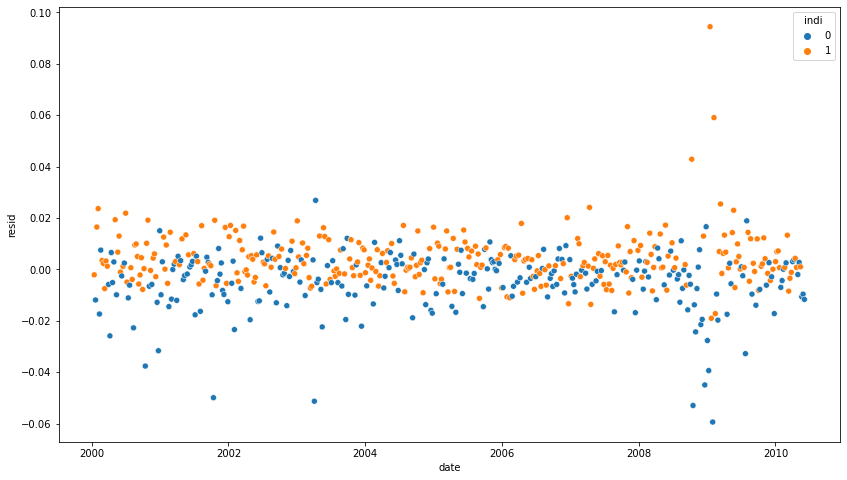

<IPython.core.display.Javascript object>

In [61]:
sns.scatterplot(data=oil, x="date", y="resid", hue="indi")

# 12

In [33]:
def read_gtemp(filename):
    df = pd.read_csv(filename)
    df.date = pd.to_datetime(df.date)

    return df

<IPython.core.display.Javascript object>

In [34]:
gtemp = read_gtemp("../data/gtemp_land.csv")

<IPython.core.display.Javascript object>

In [50]:
gtemp["ma5_centered"] = gtemp.gtemp_diff.rolling(5, center=True).mean()
gtemp["ma5"] = gtemp.gtemp_diff.rolling(5, center=False).mean()
gtemp["ma30"] = gtemp.gtemp_diff.rolling(30).mean()

gtemp['t'] = gtemp.index + 1
lowess_mod = moepy.lowess.Lowess()
lowess_mod.fit(x=gtemp['t'].to_numpy(), y=gtemp.gtemp_diff.to_numpy(), frac=0.2)
gtemp['lowess'] = lowess_mod.predict(gtemp['t'].to_numpy())


<IPython.core.display.Javascript object>

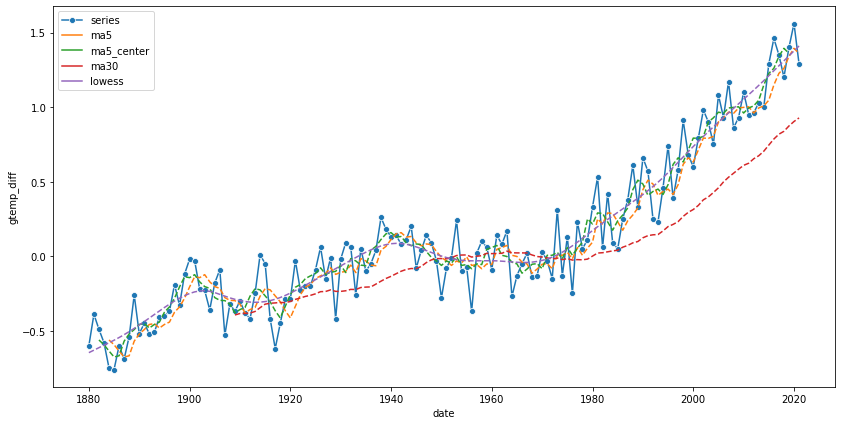

<IPython.core.display.Javascript object>

In [51]:
g = sns.lineplot(data=gtemp, x="date", y="gtemp_diff", marker="o", label="series")
sns.lineplot(data=gtemp, x="date", y="ma5", label="ma5")
sns.lineplot(data=gtemp, x="date", y="ma5_centered", label="ma5_center")
sns.lineplot(data=gtemp, x="date", y="ma30", label="ma30")
sns.lineplot(data=gtemp, x="date", y="lowess", label="lowess")

g.lines[1].set_linestyle("--")
g.lines[2].set_linestyle("--")
g.lines[3].set_linestyle("--")
g.lines[4].set_linestyle("--")

In [122]:
def gaussian_kernel(z):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-(z**2) / 2)


def weight(t, i, b, n):
    num = gaussian_kernel((t - i) / b)
    den = 0
    for j in range(1, n + 1):
        den = den + gaussian_kernel((t - j) / b)
    weight = num / den
    return weight

<IPython.core.display.Javascript object>

In [117]:
gtemp["t"] = gtemp.index + 1

<IPython.core.display.Javascript object>

In [123]:
def nadaraya_watson_smoother(df, date_col, target_col, bandwidth):
    smoothed = []
    for date in sorted(df[date_col]):
        num = (df[date_col] - date).apply(lambda x: x.days) / bandwidth
        den = num.sum()
        weight = num / den
        smoothed_val = (df[target_col] * weight).sum()
        smoothed.append(smoothed_val)
    return smoothed


gtemp["nws"] = nadaraya_watson_smoother(gtemp, "date", "gtemp_diff", 2)

<IPython.core.display.Javascript object>

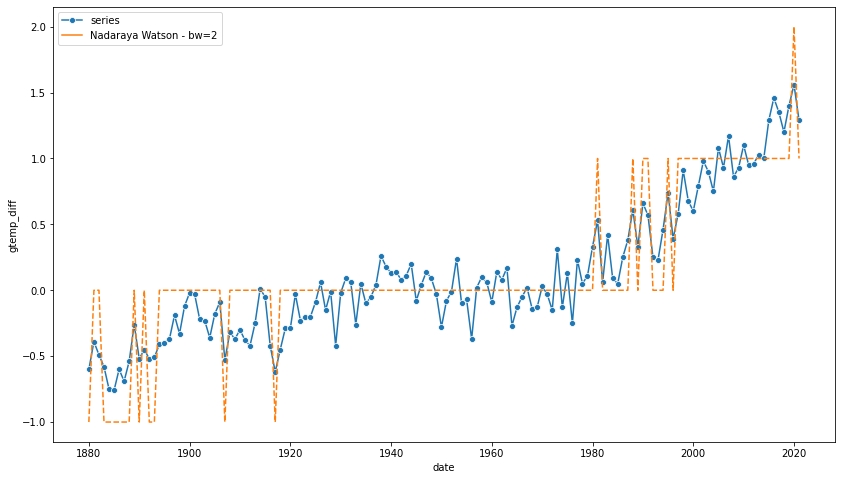

<IPython.core.display.Javascript object>

In [131]:
g = sns.lineplot(data=gtemp, x="date", y="gtemp_diff", marker="o", label="series")
sns.lineplot(data=gtemp, x="date", y="nw_smoother", label="Nadaraya Watson - bw=2")
g.lines[1].set_linestyle("--")

In [130]:
smoothed_cases = []
for date in sorted(gtemp["date"]):
    gtemp["gkv"] = np.exp(
        -(((gtemp["date"] - date).apply(lambda x: x.days)) ** 2) / (2 * (20**2))
    )
    gtemp["gkv"] /= gtemp["gkv"].sum()
    smoothed_cases.append(round(gtemp["gtemp_diff"] * gtemp["gkv"]).sum())

gtemp["nw_smoother"] = smoothed_cases

<IPython.core.display.Javascript object>

In [68]:
import scipy

<IPython.core.display.Javascript object>

In [70]:
from scipy import interpolate

dr = pd.date_range("1880-01-01", "2021-01-01")
int_range = range(0, len(dr))

int_range = range(gtemp.shape[0])

x_smooth = np.linspace(min(int_range), max(int_range), 1000)
y_smooth = scipy.interpolate.spline(int_range, y, x_smooth)

AttributeError: module 'scipy.interpolate' has no attribute 'spline'

<IPython.core.display.Javascript object>

In [ ]:
y=[ 191.78 ,   191.59,    191.59,    191.41,    191.47,    191.33,    191.25  \
  ,191.33 ,   191.48 ,   191.48,    191.51,    191.43,    191.42,    191.54    \
  ,191.5975,  191.555,   191.52 ,   191.25 ,   191.15  ,  191.01  ]
x = np.linspace(1 ,20,len(y))

# convert both to arrays
x_sm = np.array(x)
y_sm = np.array(y)

# resample to lots more points - needed for the smoothed curves
x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)

# spline - always goes through all the data points x/y
y_spline = interpolate.spline(x, y, x_smooth)

spl = interpolate.UnivariateSpline(x, y)

sigma = 2
x_g1d = ndimage.gaussian_filter1d(x_sm, sigma)
y_g1d = ndimage.gaussian_filter1d(y_sm, sigma)

fig, ax = plt.subplots(figsize=(10, 10))
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

plt.plot(x_sm, y_sm, 'green', linewidth=1)
plt.plot(x_smooth, y_spline, 'red', linewidth=1)
plt.plot(x_smooth, spl(x_smooth), 'yellow', linewidth=1)
plt.plot(x_g1d,y_g1d, 'magenta', linewidth=1)

plt.show()

In [ ]:
gtemp.date.astype("float64")

## (kernel smoothing)

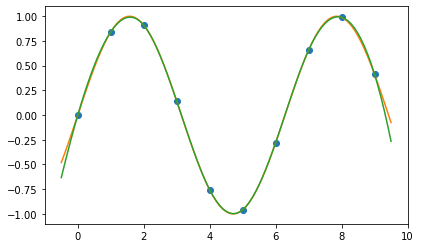

<IPython.core.display.Javascript object>

In [76]:
import numpy as np

from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

x = np.arange(10)

y = np.sin(x)

cs = CubicSpline(x, y)

xs = np.arange(-0.5, 9.6, 0.1)

fig, ax = plt.subplots(figsize=(6.5, 4))

ax.plot(x, y, 'o', label='data')

ax.plot(xs, np.sin(xs), label='true')

ax.plot(xs, cs(xs), label="S")

# ax.plot(xs, cs(xs, 1), label="S'")

# ax.plot(xs, cs(xs, 2), label="S''")

# ax.plot(xs, cs(xs, 3), label="S'''")

# ax.set_xlim(-0.5, 9.5)

# ax.legend(loc='lower left', ncol=2)

plt.show()


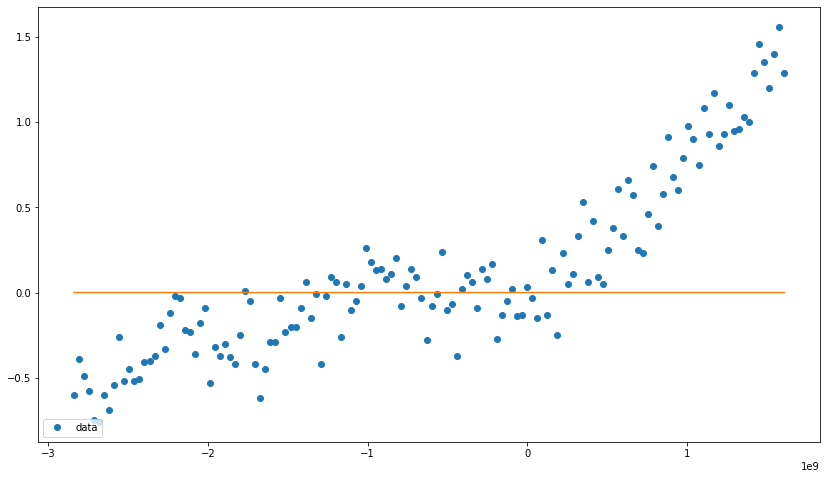

<IPython.core.display.Javascript object>

In [107]:
x = np.array((pd.date_range("1880", "2021", freq="YS").astype("int64") / 1e9))
y = np.array(gtemp.gtemp_diff)
cs = CubicSpline(x, y)

xs = np.array(pd.date_range('1880', '2021', freq='D').astype('int64') / 1e9)
fig, ax = plt.subplots()

ax.plot(x, y, 'o', label='data')

# ax.plot(xs, np.sin(xs), label='true')
ax.legend(loc='lower left', ncol=2)

ax.plot(xs, cs(xs, 200), label="S")
plt.show()


In [94]:
len(x)

142

<IPython.core.display.Javascript object>

In [95]:
len(y)

142

<IPython.core.display.Javascript object>

In [99]:
xs

DatetimeIndex(['1880-01-01', '1880-01-02', '1880-01-03', '1880-01-04',
               '1880-01-05', '1880-01-06', '1880-01-07', '1880-01-08',
               '1880-01-09', '1880-01-10',
               ...
               '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-26',
               '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30',
               '2020-12-31', '2021-01-01'],
              dtype='datetime64[ns]', length=51501, freq='D')

<IPython.core.display.Javascript object>

In [89]:
gtemp.date.unique()

array(['1880-01-01T00:00:00.000000000', '1881-01-01T00:00:00.000000000',
       '1882-01-01T00:00:00.000000000', '1883-01-01T00:00:00.000000000',
       '1884-01-01T00:00:00.000000000', '1885-01-01T00:00:00.000000000',
       '1886-01-01T00:00:00.000000000', '1887-01-01T00:00:00.000000000',
       '1888-01-01T00:00:00.000000000', '1889-01-01T00:00:00.000000000',
       '1890-01-01T00:00:00.000000000', '1891-01-01T00:00:00.000000000',
       '1892-01-01T00:00:00.000000000', '1893-01-01T00:00:00.000000000',
       '1894-01-01T00:00:00.000000000', '1895-01-01T00:00:00.000000000',
       '1896-01-01T00:00:00.000000000', '1897-01-01T00:00:00.000000000',
       '1898-01-01T00:00:00.000000000', '1899-01-01T00:00:00.000000000',
       '1900-01-01T00:00:00.000000000', '1901-01-01T00:00:00.000000000',
       '1902-01-01T00:00:00.000000000', '1903-01-01T00:00:00.000000000',
       '1904-01-01T00:00:00.000000000', '1905-01-01T00:00:00.000000000',
       '1906-01-01T00:00:00.000000000', '1907-01-01

<IPython.core.display.Javascript object>

<AxesSubplot: xlabel='x', ylabel='y'>

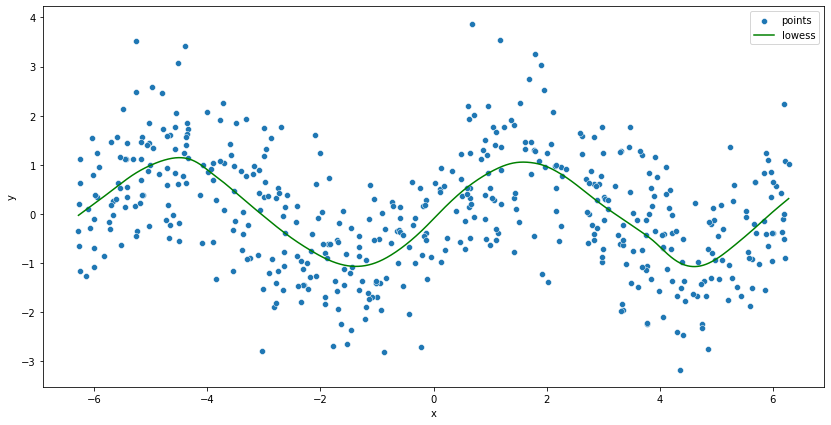

<IPython.core.display.Javascript object>

In [32]:
lowess = sm.nonparametric.lowess
x = np.random.uniform(low=-2 * np.pi, high=2 * np.pi, size=500)
y = np.sin(x) + np.random.normal(size=len(x))

lowess_model = moepy.lowess.Lowess()
lowess_model.fit(x,y, frac=0.2)
x_pred = np.linspace(x.min(), x.max(), 100*len(x))
y_pred = lowess_model.predict(x_pred)

df = pd.DataFrame({
    'x': x, 'y': y
})
df2 = pd.DataFrame({
    'x': x_pred, 'y': y_pred
})
plt.rcParams['figure.figsize'] = (14, 7)
sns.scatterplot(data=df, x='x', y='y', label='points')
sns.lineplot(data=df2, x='x', y='y', label='lowess', color='green')
